<center><br><font size=10>Final Project</font><br>
<br><br>
<b>Introduction to Machine Learning – Digital Sciences for High-Tech</b>
<br><br>
<b>Author</b>: Asaf Biniamini & Guy Maoz
<br><i>Spring 2023</i> </center>

## Import libraries

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix
from typing import List, Dict
%matplotlib inline

#My imports: 
import seaborn as sns
import jinja2 as jnj
import time


In [2]:
# load
data = pd.read_csv("train.csv")
#Converting data to numpy arrays
X, y = data.values[:,:-1], data.values[:, -1]
print(f'X.shape: {X.shape}, y.shape: {y.shape}')

X.shape: (60000, 23), y.shape: (60000,)


# Part 1: Explorization

In [3]:
#Get a first look on the data set
# data.head()
# data.tail()
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sha256               60000 non-null  object 
 1   size                 60000 non-null  int64  
 2   vsize                58065 non-null  float64
 3   imports              58261 non-null  float64
 4   exports              57907 non-null  float64
 5   has_debug            57073 non-null  float64
 6   has_relocations      56676 non-null  float64
 7   has_resources        58039 non-null  float64
 8   has_signature        58063 non-null  float64
 9   has_tls              57102 non-null  float64
 10  symbols              57344 non-null  float64
 11  numstrings           57282 non-null  float64
 12  paths                56340 non-null  float64
 13  urls                 57651 non-null  float64
 14  registry             57475 non-null  float64
 15  MZ                   56911 non-null 

Based on the Feature information we have, we know that the Sha256 feature is a unique identifier for the file. <br>
We assume that it will not help us to predict if the file is malicious, and we have 60,000 different samples of identifiers, so it will be impossible to work with. So we decided to remove it from the data. 

In [4]:
data_without_sha = data.drop("sha256", axis=1)

In [5]:
pd.set_option('display.max_columns', None)
data_without_sha.describe()

,size,vsize,imports,exports,has_debug,has_relocations,has_resources,has_signature,has_tls,symbols,numstrings,paths,urls,registry,MZ,printables,avlength,file_type_prob_trid,A,B,label
count,6.000000e+04,5.806500e+04,58261.000000,57907.000000,57073.000000,56676.000000,58039.000000,58063.000000,57102.000000,57344.000000,5.728200e+04,56340.000000,57651.000000,57475.000000,56911.000000,5.726100e+04,57243.000000,60000.000000,56296.000000,56249.000000,60000.000000
mean,1.501019e+06,1.965704e+06,106.195671,30.803271,0.403764,0.543069,0.860456,0.254189,0.234195,40.172468,7.404344e+03,1.644799,12.501292,0.429282,16.263429,1.207710e+05,32.658511,53.678748,4.015404,5.810361,0.500000
std,4.727391e+06,2.017881e+07,213.452315,508.079533,0.490655,0.498146,0.346516,0.435408,0.423498,1239.701661,2.463088e+04,37.003752,71.631716,11.496862,82.193088,6.052203e+05,1094.710748,20.632479,6.368440,0.641208,0.500004
min,2.980000e+02,5.440000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000,0.000000,0.000000,1.000000,5.000000e+00,5.000000,17.500000,-17.783199,0.004929,0.000000
25%,1.070080e+05,1.228800e+05,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,4.750000e+02,0.000000,0.000000,0.000000,1.000000,6.013000e+03,7.447368,38.400000,-0.293525,5.469978,0.000000
50%,4.833280e+05,4.218880e+05,28.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.990500e+03,0.000000,0.000000,0.000000,4.000000,2.283500e+04,12.009456,43.300000,3.658333,5.856659,0.500000
75%,1.239326e+06,1.601536e+06,152.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,5.172000e+03,1.000000,10.000000,0.000000,11.000000,7.615600e+04,17.310647,69.100000,7.863973,6.344090,1.000000
max,3.253537e+08,4.278288e+09,15047.000000,48840.000000,1.000000,1.000000,1.000000,1.000000,1.000000,181660.000000,1.572261e+06,5324.000000,9387.000000,2492.000000,7010.000000,5.034687e+07,207990.925620,100.000000,43.926598,6.584937,1.000000


#### Conclusion from the describe table
1. We can see that the 5 "has_###" features are (as expected) a binary variables. So we can change they're type to be boolean to emphasize that and deal with them differntly.
2. We also noticed that the labels mean value is exactly 0.5, which means that we have same numbers of '1' labels as '0' labels. so based on it we can conclude that the probability to get malicious file is the same as the probability to get non malicious file.
3. We have noticed most of the continous features has a very large differnece between the 75th percentile value to the max value. like 'eports' for example that has '0' value in it 75th percentile and '48840' max value. This can light some warning signs that the outliars affects the histograms that we saw before and made problems to notice how feature is distribute.

Now I want to get some data on each feature and try to understand them


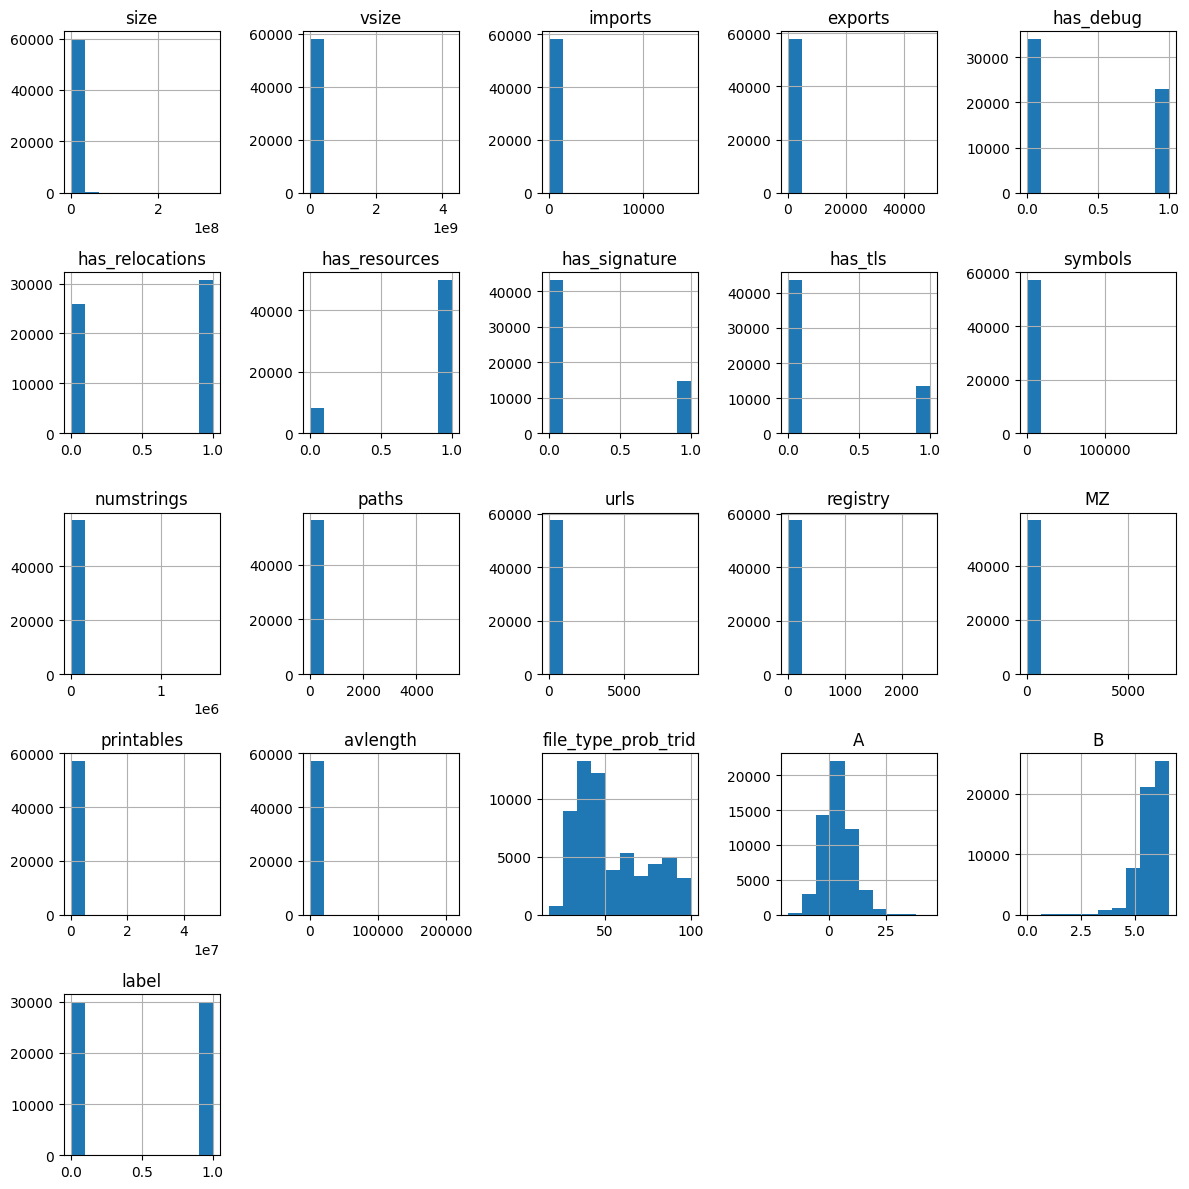

In [6]:
data_without_sha.hist(figsize=(12, 12))
plt.tight_layout()
plt.show()

C:\Users\asafb\AppData\Local\Temp\ipykernel_10296\247836213.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data_without_sha.corr()


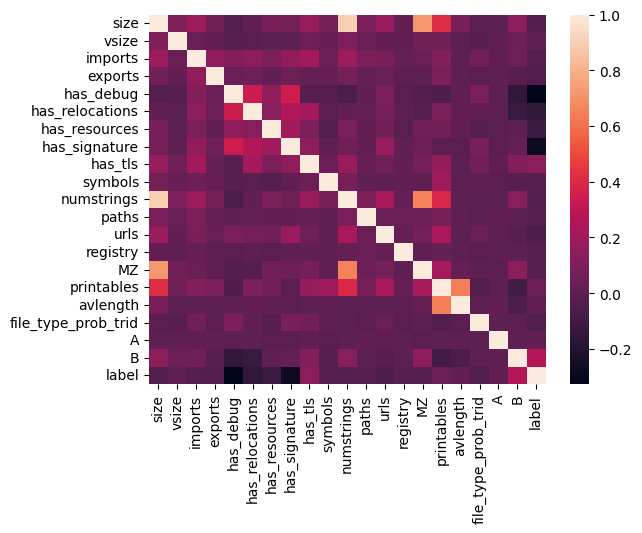

In [7]:
# Check the corellation between features:
corr_matrix = data_without_sha.corr()
corr_heatmap = sns.heatmap(corr_matrix, 
        xticklabels=corr_matrix.columns,
        yticklabels=corr_matrix.columns)

We can see that most of the features does *not* have high correlation between one another.
But there are some that does have high correlation and maybe should be removed.

In [8]:
# get upper triangle of correlation matrix

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# find features with correlation greater than 0.85

to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

print(f'Features to drop are: {to_drop}')

# drop highly correlated features

data_without_numstrings = data_without_sha.drop(to_drop, axis=1, inplace=False)
print(f'new data columns: \n {data_without_numstrings.columns}')

Features to drop are: ['numstrings']
new data columns: 
 Index(['size', 'vsize', 'imports', 'exports', 'has_debug', 'has_relocations',
       'has_resources', 'has_signature', 'has_tls', 'symbols', 'paths', 'urls',
       'registry', 'MZ', 'printables', 'avlength', 'file_type_trid',
       'file_type_prob_trid', 'A', 'B', 'C', 'label'],
      dtype='object')


# Part 2 - Pre Processing

In [9]:
# Configurable parameters
iqr_value = 2
num_catogeries = 5

### Are there outliers in the data? If so, you must remove them or at least give explanation about it.

To determine if there are outliers in the data, we did the next steps:

a. Explore the data: Begin by gaining a general understanding of the data by examining its summary statistics, such as mean, median, standard deviation, minimum, and maximum values. This will give us a rough idea of the range and distribution of our features.

b. Visualize the data: Create visualizations like histograms, box plots, or scatter plots to visually identify any potential outliers. These plots can help us identify data points that deviate significantly from the majority of the data.

c. Analyze feature distributions: Examine the distribution of each feature individually to identify any unusual patterns or extreme values. Outliers can be identified as data points that fall far outside the range of the bulk of the data.

d. Use statistical techniques: Apply statistical methods like the Z-score or the interquartile range (IQR) to detect outliers. The Z-score measures how many standard deviations a data point is away from the mean, while the IQR measures the spread of data around the median. Data points that fall outside a certain threshold (e.g., 3 standard deviations for Z-score or 1.5 times the IQR) can be considered outliers.

Once we have identified the outliers, we have a few options:

Remove the outliers: If the outliers are due to measurement errors or data entry mistakes, we can choose to remove them from the dataset.

Transform the data: Instead of removing outliers, we can apply data transformation techniques like winsorization or log transformation to mitigate the impact of outliers on our model.

Treat outliers as a separate category: In some cases, outliers may contain valuable information or represent rare events. If that's the case, we can create a separate category or flag for outliers to be included in our analysis.


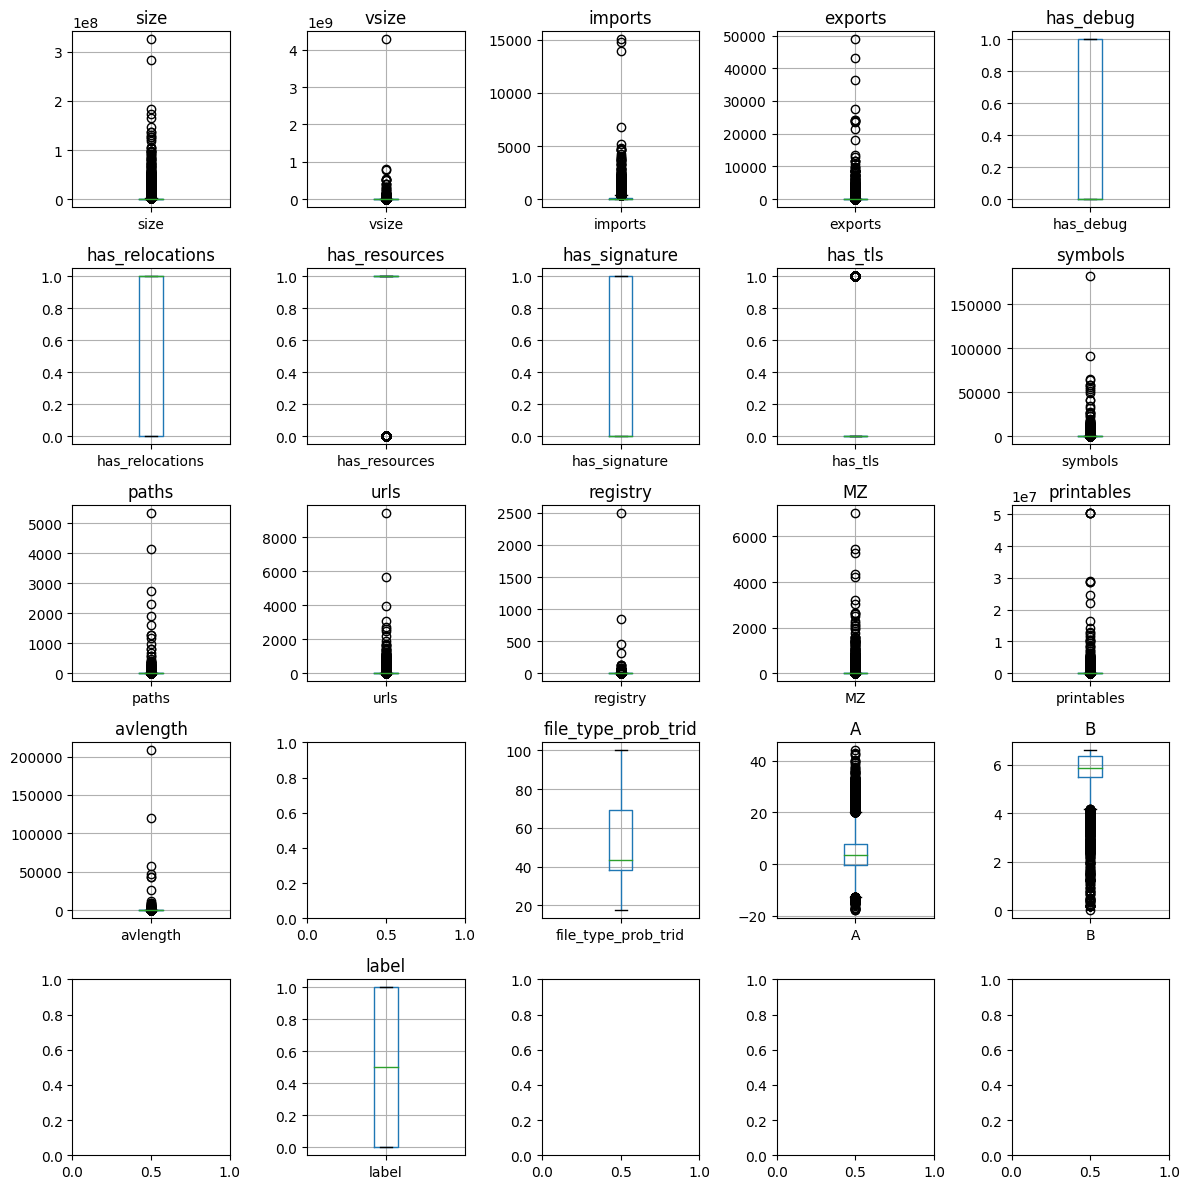

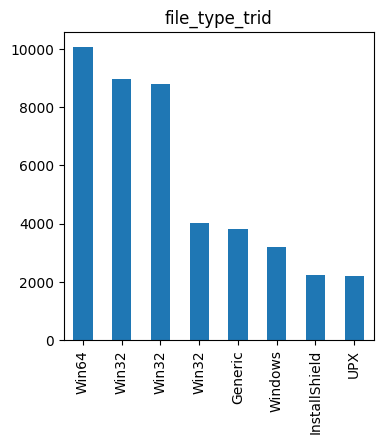

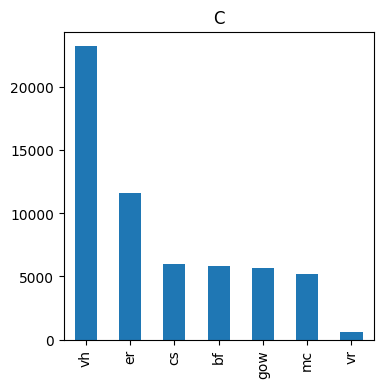

Number of outliers detected: 34291
Number of data points after handling outliers: 25709
Runtime: 3.71 seconds


In [12]:
t0 = time.time() # for Runtime measurement
 
# Step 3: Analyze feature distributions
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(12, 12))
axes = axes.flatten()

for i, column in enumerate(data_without_numstrings.columns):
    if column != "file_type_trid" and column != "C":
        data_without_numstrings.boxplot(column=[column], ax=axes[i])
        axes[i].set_title(column)
        axes[i].set_ylabel("")
        axes[i].set_xlabel("")
        
plt.tight_layout()
plt.show()
        
        
feature_file_type_trid_counts = data_without_numstrings["file_type_trid"].value_counts()
top_categories = feature_file_type_trid_counts[:8]
top_categories.index = top_categories.index.str.split().str[0]  # Extracting the first word of each string
top_categories.plot(kind="bar", figsize=(4, 4))
plt.title("file_type_trid")
plt.show()



feature_C_counts = data_without_numstrings["C"].value_counts()
feature_C_counts.plot(kind="bar", figsize=(4, 4))
plt.title("C")
plt.show()

# Step 4: Use statistical techniques (IQR method)
numeric_columns = data_without_numstrings.select_dtypes(include=[np.number]).columns
numeric_data = data_without_numstrings[numeric_columns].copy()

Q1 = numeric_data.quantile(0.25)
Q3 = numeric_data.quantile(0.75)
IQR = Q3 - Q1

lower_threshold = Q1 - iqr_value * IQR
upper_threshold = Q3 + iqr_value * IQR

outliers = ((numeric_data < lower_threshold) | (numeric_data > upper_threshold)).any(axis=1)

# Remove outliers
data_without_outliars = data_without_numstrings[~outliers]

# Print the number of outliers detected
num_outliers = outliers.sum()
print("Number of outliers detected:", num_outliers)

# Print the number of data points after handling outliers
num_data_points = len(data_without_outliars)
print("Number of data points after handling outliers:", num_data_points)


print(f'Runtime: {round(time.time()-t0,2)} seconds')

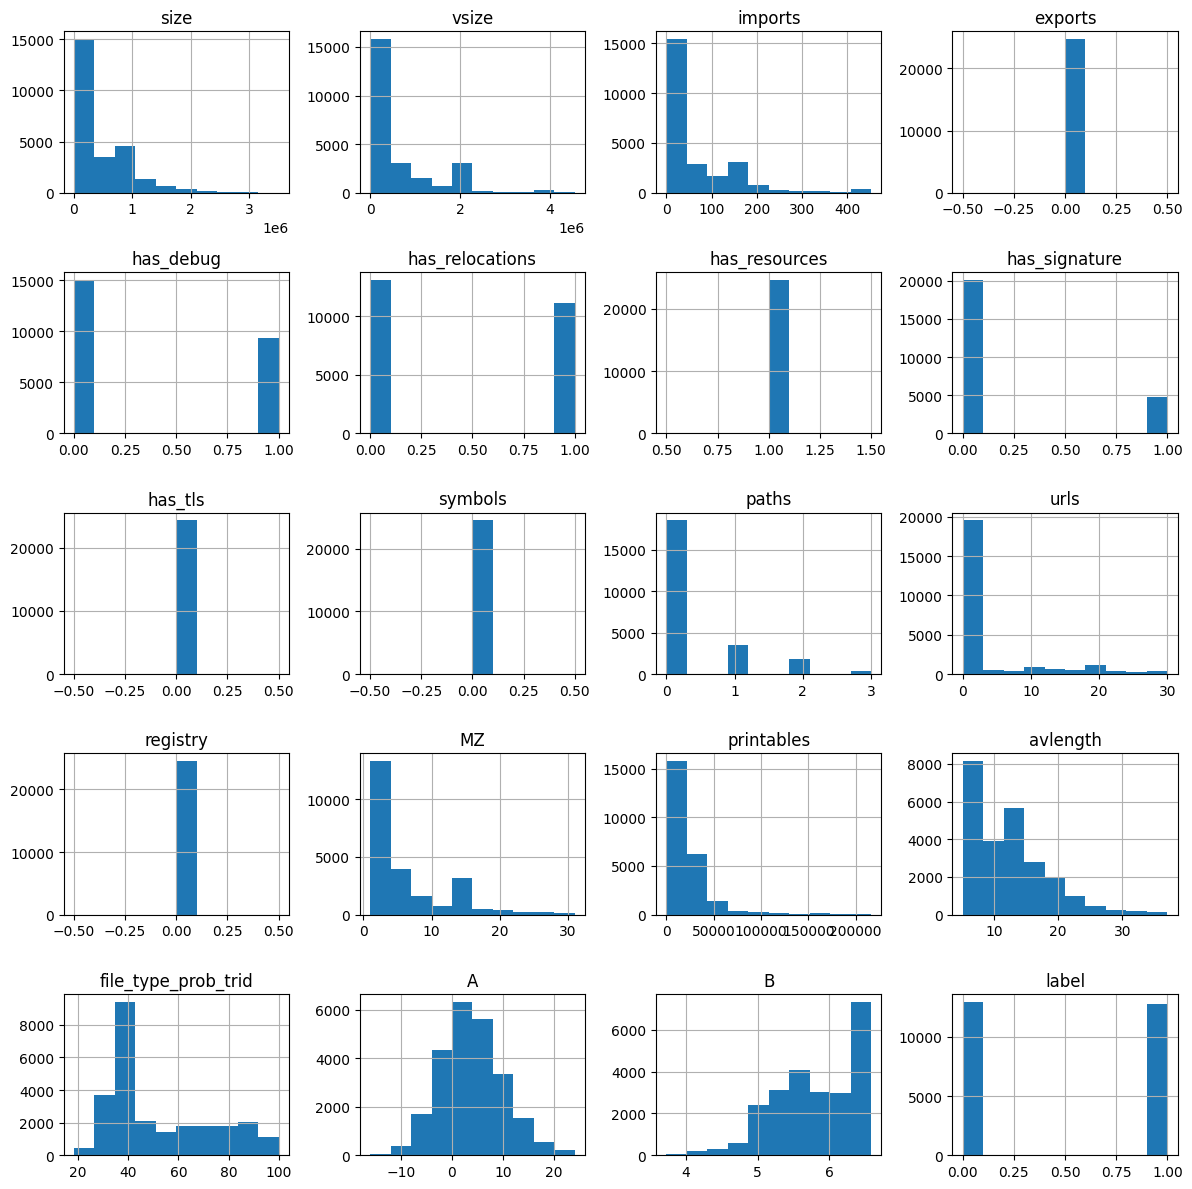

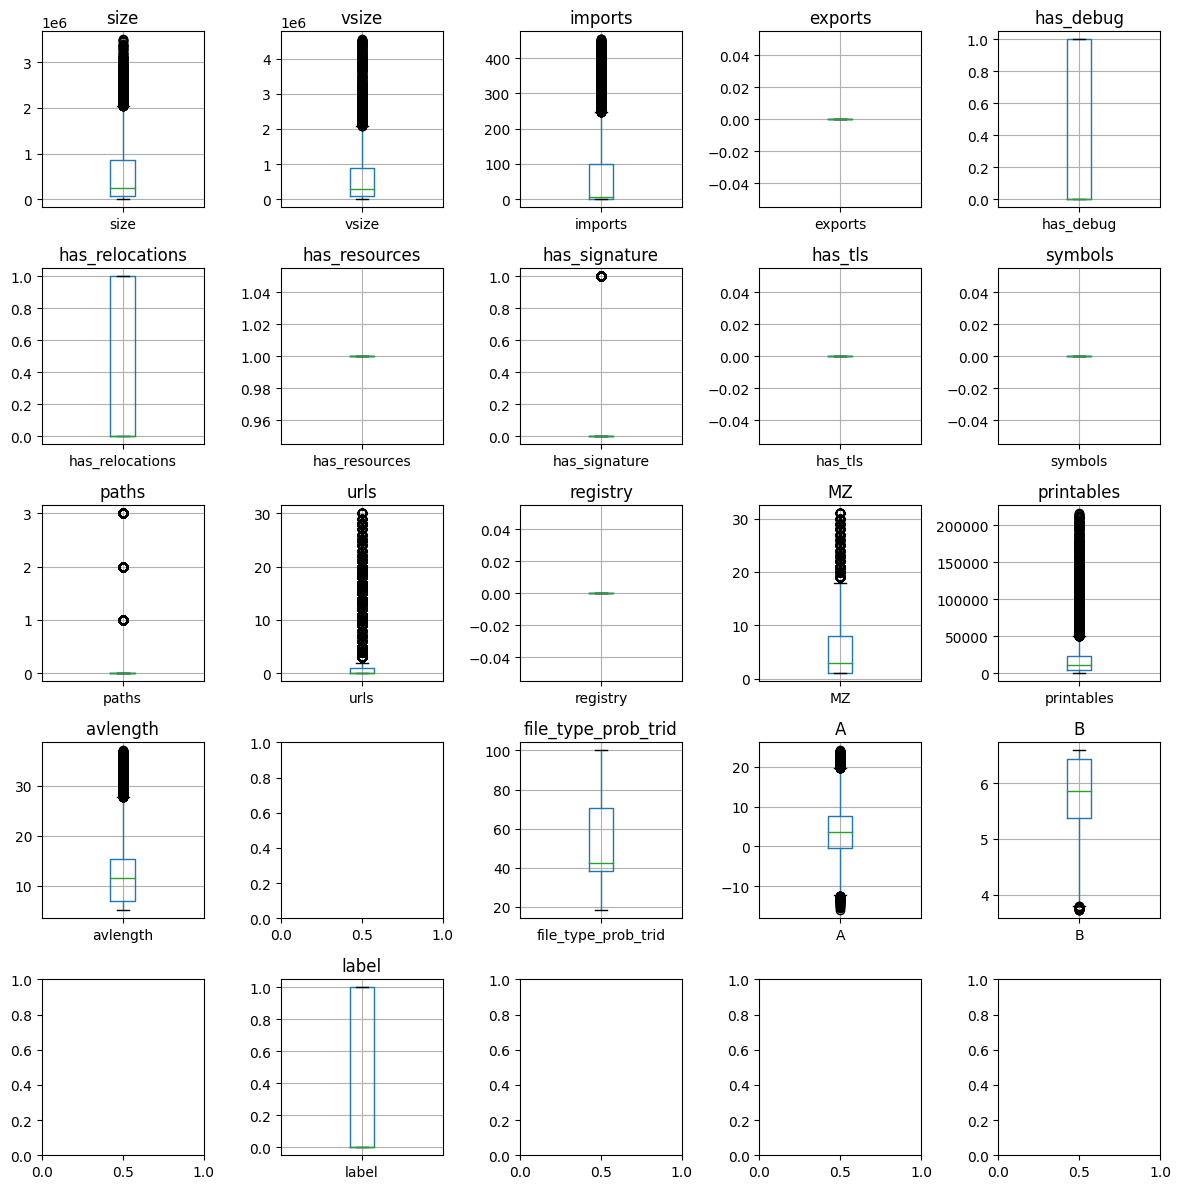

In [13]:
# Step 5: Visualize the data after removing outliers
data_without_outliars.drop(["file_type_trid", "C"], axis=1).hist(figsize=(12, 12))
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(12, 12))
axes = axes.flatten()

for i, column in enumerate(data_without_outliars.columns):
    if column != "file_type_trid" and column != "C":
        data_without_outliars.boxplot(column=[column], ax=axes[i])
        axes[i].set_title(column)
        axes[i].set_ylabel("")
        axes[i].set_xlabel("")

plt.tight_layout()
plt.show()

##### we still not sure about the right way to deal with outliers so we continue from here without take them out

### Is the data normalized? If not - should they be normalized? What is the importance of normalizing the data in the problem?

Identify Missing Data

In [14]:
# Check the number of NULL values of each feature: 
data_without_numstrings.isnull().sum()

size                      0
vsize                  1935
imports                1739
exports                2093
has_debug              2927
has_relocations        3324
has_resources          1961
has_signature          1937
has_tls                2898
symbols                2656
paths                  3660
urls                   2349
registry               2525
MZ                     3089
printables             2739
avlength               2757
file_type_trid            0
file_type_prob_trid       0
A                      3704
B                      3751
C                      2051
label                     0
dtype: int64

Try to remove rows with missing data

In [15]:
data_drop_null = data_without_numstrings.dropna()
X, y = data_drop_null.values[:,:-1], data_drop_null.values[:, -1]
print(f'X.shape: {X.shape}, y.shape: {y.shape}')

X.shape: (26351, 21), y.shape: (26351,)


### Dealing with categorical features

We have 2 categorical features - ["file_type_trid", "C"] that we have to deal with them.

In [16]:
data_drop_null.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26351 entries, 0 to 59998
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   size                 26351 non-null  int64  
 1   vsize                26351 non-null  float64
 2   imports              26351 non-null  float64
 3   exports              26351 non-null  float64
 4   has_debug            26351 non-null  float64
 5   has_relocations      26351 non-null  float64
 6   has_resources        26351 non-null  float64
 7   has_signature        26351 non-null  float64
 8   has_tls              26351 non-null  float64
 9   symbols              26351 non-null  float64
 10  paths                26351 non-null  float64
 11  urls                 26351 non-null  float64
 12  registry             26351 non-null  float64
 13  MZ                   26351 non-null  float64
 14  printables           26351 non-null  float64
 15  avlength             26351 non-null 

In [17]:
# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Fit and transform the "file_type_trid" feature
file_type_encoded = encoder.fit_transform(data_drop_null[['file_type_trid']])
file_type_categories = encoder.categories_[0]
file_type_encoded_df = pd.DataFrame(file_type_encoded, columns=[f'file_type_{c}' for c in file_type_categories])

# Fit and transform the "C" feature
C_encoded = encoder.fit_transform(data_drop_null[['C']])
C_categories = encoder.categories_[0]
C_encoded_df = pd.DataFrame(C_encoded, columns=[f'C_{c}' for c in C_categories])

# Concatenate the encoded features with the original DataFrame
data_encoded = pd.concat([data_drop_null, file_type_encoded_df, C_encoded_df], axis=1)

# Print the encoded data
print(data_encoded)

             size      vsize  imports  exports  has_debug  has_relocations  \
0       6744064.0  6799360.0    524.0      3.0        0.0              1.0   
1         22016.0    45056.0      2.0      0.0        0.0              0.0   
2        686136.0   704512.0    133.0      4.0        1.0              1.0   
7          9778.0    40960.0      1.0      0.0        0.0              0.0   
8      22023403.0  1069056.0    333.0      0.0        1.0              0.0   
...           ...        ...      ...      ...        ...              ...   
26343         NaN        NaN      NaN      NaN        NaN              NaN   
26347         NaN        NaN      NaN      NaN        NaN              NaN   
26348         NaN        NaN      NaN      NaN        NaN              NaN   
26349         NaN        NaN      NaN      NaN        NaN              NaN   
26350         NaN        NaN      NaN      NaN        NaN              NaN   

       has_resources  has_signature  has_tls  symbols  paths  u

C:\Users\asafb\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\asafb\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


##### we still not sure about the right way to deal with categorical features so we continue from here without deailing with them

In [18]:
data_without_categorical = data_drop_null.drop(['file_type_trid','C'], axis=1)
data_without_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26351 entries, 0 to 59998
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   size                 26351 non-null  int64  
 1   vsize                26351 non-null  float64
 2   imports              26351 non-null  float64
 3   exports              26351 non-null  float64
 4   has_debug            26351 non-null  float64
 5   has_relocations      26351 non-null  float64
 6   has_resources        26351 non-null  float64
 7   has_signature        26351 non-null  float64
 8   has_tls              26351 non-null  float64
 9   symbols              26351 non-null  float64
 10  paths                26351 non-null  float64
 11  urls                 26351 non-null  float64
 12  registry             26351 non-null  float64
 13  MZ                   26351 non-null  float64
 14  printables           26351 non-null  float64
 15  avlength             26351 non-null 

### Is the data normalized? If not - should they be normalized? What is the importance of normalizing the data in the problem?

Normalization is the process of scaling numeric features to a standard range, typically between 0 and 1 or -1 and 1. Here are a few reasons why normalization is important in machine learning problems:

Equalizes the scales: Different features might have different scales, which can affect the performance of certain machine learning algorithms. By normalizing the data, we bring all features to a similar scale, ensuring that they contribute equally during the model training process.

Avoids dominance of certain features: When features have significantly different scales, those with larger scales can dominate the learning process and overshadow the influence of other features. Normalization prevents this dominance, allowing all features to contribute more equally to the model's learning process.

Improves convergence: Many optimization algorithms used in machine learning, such as gradient descent, converge faster on normalized data. Normalization helps to avoid oscillations and overshooting in the optimization process, leading to quicker convergence and more stable models.

Facilitates interpretation and comparison: Normalized data is easier to interpret and compare. The values are on a consistent scale, making it simpler to understand the impact of different features and compare their relative importance in the model.

In summary, normalizing the data can help improve the performance, stability, and interpretability of machine learning models by equalizing feature scales, avoiding dominance, facilitating convergence, and simplifying interpretation and comparison of feature importance.

In [19]:
# Select the features to be normalized
#features_to_normalize = data_drop_null.columns.drop(["file_type_trid", "C"])
features_to_normalize = data_without_categorical.columns

# Create a copy of the original DataFrame
data_normalized = data_without_categorical.copy()

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Normalize only the selected features
data_normalized[features_to_normalize] = scaler.fit_transform(data_normalized[features_to_normalize])

# Print the normalized DataFrame
print(data_normalized)


           size     vsize   imports   exports  has_debug  has_relocations  \
0      0.020728  0.001589  0.035463  0.000070        0.0              1.0   
1      0.000067  0.000010  0.000135  0.000000        0.0              0.0   
2      0.002108  0.000165  0.009001  0.000093        1.0              1.0   
7      0.000029  0.000009  0.000068  0.000000        0.0              0.0   
8      0.067690  0.000250  0.022537  0.000000        1.0              0.0   
...         ...       ...       ...       ...        ...              ...   
59987  0.000578  0.000052  0.000744  0.000000        1.0              1.0   
59989  0.000010  0.000005  0.000541  0.000000        0.0              1.0   
59992  0.000334  0.000030  0.001489  0.000000        1.0              0.0   
59997  0.000029  0.000009  0.000068  0.000000        0.0              0.0   
59998  0.000338  0.000025  0.000068  0.000000        0.0              1.0   

       has_resources  has_signature  has_tls  symbols     paths      urls  

### Is the dimensionality of the problem too large? Why can large dimensionality create a problem? How will we recognize that the dimensions of the problem are too large?

The dimensionality of a problem refers to the number of features or variables in the dataset. When the dimensionality of the problem is too large, it can create several challenges and problems:

1. Curse of Dimensionality: As the number of features increases, the amount of data required to generalize accurately grows exponentially. This is known as the curse of dimensionality. With high-dimensional data, the data points become increasingly sparse, making it difficult to find meaningful patterns and relationships.

2. Increased Computational Complexity: High-dimensional data requires more computational resources and time to process, analyze, and build models. Algorithms and techniques that work well with low-dimensional data may become inefficient or even infeasible in high-dimensional spaces.

3. Overfitting: With a large number of features, there is an increased risk of overfitting, where a model learns noise or irrelevant patterns from the data, leading to poor generalization performance on unseen data. Overfitting occurs when the model becomes too complex relative to the available data.

4. Difficulty in Visualization: Visualizing data beyond three dimensions becomes challenging for humans. As the number of dimensions increases, it becomes nearly impossible to visualize and gain insights from the data using traditional plots and graphs.

To recognize that the dimensions of the problem are too large, we can consider the following indicators:

- High Dimensionality: If the number of features is much larger than the number of observations or samples, it suggests high dimensionality.
- Computational Constraints: If the computational resources (memory, processing power, etc.) required to handle the data become a limitation, it indicates large dimensionality.
- Overfitting and Poor Generalization: If the model performs well on the training data but poorly on the test or validation data, it may be a sign of overfitting caused by high dimensionality.
- Difficulty in Interpretation: If the relationships between variables become complex and difficult to interpret or explain, it suggests a large number of dimensions.

In such cases, dimensionality reduction techniques like Principal Component Analysis (PCA) or feature selection methods can be employed to reduce the number of features and address the challenges associated with high dimensionality.

### Dimensionality reduction by one technique learned in class - PCA, and/or by selecting a subset of existing features (feature selection).
### How did the dimensionality reduction affect the model?

#### backward selection

In [20]:
def get_sigma_hat_squared(X: np.array, y: np.array) -> float:
    """
    Returns sigma_hat squared - an estimate of the noise variance sigma
    X: 2d np.array with the data.
    y: labels
    return: float - the sigma hat squared.
    """
    LrModel = LinearRegression()
    LrModel.fit(X, y)
    RSS = np.sum((y - LrModel.predict(X)) ** 2)
    sigma_hat_squared = RSS / (X.shape[0] - X.shape[1] - 1)
    return sigma_hat_squared

def get_mallows_cp_score(X: np.array ,y: np.array, sigma_hat_squared: float) -> float:
    """
    Returns mallow cp score for given data, selected features and train model.
    X: 2d numpy array of data with only selected features
    y: 1d numpy array of labels (also knows as target values)
    sigma_hat_squared: the estimate for noise variance
    """
    LrModel = LinearRegression()
    LrModel.fit(X, y)
    MSE = mean_squared_error(y, LrModel.predict(X))
    Cp = MSE + 2 * (X.shape[1] + 1) * sigma_hat_squared / n
    return Cp

def remove_feature(X: np.array ,y: np.array ,current_features: List[int] , sigma_hat_squared: float) -> Dict:
    """
    Returns dictionary with list of features including the best subset of features and the cp score of the model for that subset.
    X: 2d np array with all the features.
    y: 1d np array with the labels
    current_features: list of indexes which represent the features which are already included
    sigma_hat_squared: the estimate for noise variance
    returns: A dictionary with 2 keys:
            'features': a sorted list of indexes containing the features of the best model  -> current_features - [removed]
            'score': the mallows cp score of that model
    """
    best_features_lst = []
    best_score = np.inf
    
    for i in current_features:
        new_features_lst = current_features.copy()
        new_features_lst.remove(i)
        X_new = X[:, new_features_lst]
        model = LinearRegression()
        model.fit(X_new, y)
        RSS = np.sum((y - model.predict(X_new)) ** 2)
        d = len(new_features_lst)
        n = X_new.shape[0]
        Cp = RSS / n + 2 * (d + 1) * sigma_hat_squared / n
        if Cp < best_score:
            best_score = Cp
            best_features_lst = new_features_lst
            
    return {'features':sorted(best_features_lst),'score':best_score}

def backward_selection(X: np.array, y: np.array) -> List[int]:
    """
    returns list of indexes for the selected features
    X: 2d numpy array with original training data
    y: numpy vector with targets of training data
    returns: a sorted list containing the indexes of the selected features
    """
    # Calculate error on model with all features
    sigma_hat_squared = get_sigma_hat_squared(X, y)
    # set initial features to all features
    current_features = list(range(X.shape[1]))
    models_lst = []
    #perform backward selection
    while len(current_features) > 1:
        # remove feature
        model = remove_feature(X, y, current_features, sigma_hat_squared)
        #update
        current_features = model['features']
        models_lst.append(model)
    #Plotting
    scores_lst = [x['score'] for x in models_lst]
    plt.plot(range(1,len(scores_lst)+1),scores_lst)
    plt.xlabel("number of features")
    plt.ylabel("Mallows cp")
    plt.title("Mallows Cp score VS number of features")
    plt.show()

    #Returning features of best model, based on mcp score
    best_model = min(models_lst, key = lambda x: x['score'])
    best_features = best_model['features']
    return sorted(best_features)

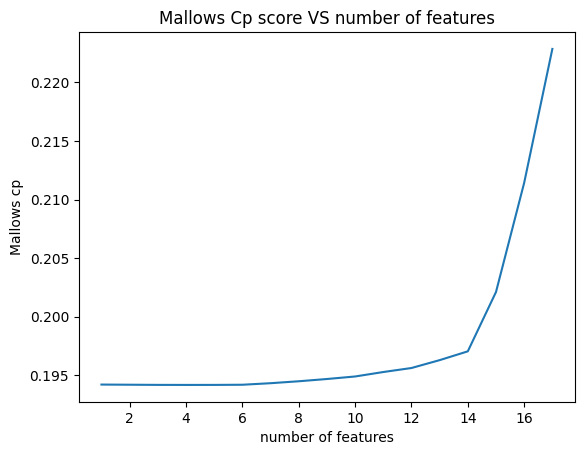

number of selected features by backward: 14


In [22]:
X, y = data_normalized.values[:,1:-1], data_normalized.values[:, -1]
res = backward_selection(X,y)
print(f'number of selected features by backward: {len(res)}')

In [23]:
# Define a list of feature names
feature_names = list(data_normalized.columns)[1:-1]  # Exclude the 'label' column

# Map the indexes to feature names
selected_features = [feature_names[i] for i in res]

# Print the selected features
print("Selected Features:")
for feature in selected_features:
    print(feature)


Selected Features:
vsize
exports
has_debug
has_relocations
has_resources
has_signature
has_tls
symbols
paths
registry
MZ
printables
file_type_prob_trid
B


In [24]:
# Create the new dataset with selected features
data_after_backward_selection = data_normalized[selected_features].copy()
print(data_after_backward_selection)

          vsize   exports  has_debug  has_relocations  has_resources  \
0      0.001589  0.000070        0.0              1.0            1.0   
1      0.000010  0.000000        0.0              0.0            1.0   
2      0.000165  0.000093        1.0              1.0            1.0   
7      0.000009  0.000000        0.0              0.0            0.0   
8      0.000250  0.000000        1.0              0.0            1.0   
...         ...       ...        ...              ...            ...   
59987  0.000052  0.000000        1.0              1.0            1.0   
59989  0.000005  0.000000        0.0              1.0            0.0   
59992  0.000030  0.000000        1.0              0.0            1.0   
59997  0.000009  0.000000        0.0              0.0            0.0   
59998  0.000025  0.000000        0.0              1.0            1.0   

       has_signature  has_tls  symbols     paths  registry        MZ  \
0                0.0      1.0      0.0  0.000000       0.0  0.0

#### PCA

In [26]:
def get_principal_components(X: np.array, p: float) -> np.array:
    """
    Returns array of principal components explaining (100*p)% of the variance
    X: 2d numpy array of data we want to apply PCA on. 
    p: float in the range (0,1]. The proportion of variance explained by components
    """
    pca = PCA(p)
    pca.fit(X)
    
    return pca.components_


In [27]:
X, y = data_normalized.values[:,1:-1], data_normalized.values[:, -1]
components = get_principal_components(X,0.99)
print(f'number of components which preserve at least 99% of the variance: {len(components)}')

number of components which preserve at least 99% of the variance: 8


In [28]:
# List of selected principal components
selected_components = components[:8]  # Assuming you want to keep the first 8 components

# Perform dimensionality reduction by projecting the data onto the selected components
data_after_pca = X @ selected_components.T

# Create a new DataFrame with the reduced-dimensional data
data_after_pca = pd.DataFrame(data_after_pca, columns=["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8"])

print(data_after_pca)

            PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0      0.991393  1.106159  0.076388 -0.041170 -0.840051  0.635100  0.208225   
1      0.156472  0.015753  0.340221 -0.282750 -0.853194  0.341503  0.388643   
2      1.827981 -0.277109  0.374996 -0.428985 -0.427626  0.787625  0.289701   
3      0.016977  0.012163  0.105184  0.106162  0.110191  0.982311  0.288787   
4      0.743722 -0.538436  0.332322  0.267667 -0.961773  0.141965  0.133591   
...         ...       ...       ...       ...       ...       ...       ...   
26346  1.810112 -0.269354  0.348362 -0.476102 -0.473709  0.347946  0.274356   
26347  0.616804  0.358861 -0.576509 -0.278722  0.060337  0.350548  0.202994   
26348  0.746492 -0.540483  0.334935  0.274994 -0.954669  0.206889  0.256102   
26349  0.016984  0.012179  0.105216  0.106134  0.110171  0.982324  0.280193   
26350  1.214410  0.287984  0.338467 -1.055193 -0.393536  0.289236  0.217251   

            PC8  
0     -0.868553  
1     -0.875081